In [87]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import load_preprocessed_climate

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this, aside from font.size:
 
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

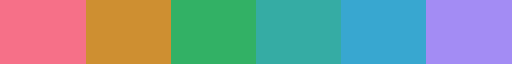

In [4]:
cmap_subset

### Load Data

In [5]:
filepath = '../data/climate'
shape_file_path = os.path.join(filepath, 'climate_divisions/climate_divisions.shp')
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shape_file_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

data_file_path = os.path.join(filepath, 'climate.csv')
climate_data = pd.read_csv(data_file_path, dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

'''
# Using seasons instead of months:
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)
'''
    
# Normalize the data
data = climate_change.to_numpy()
feature_labels = list(climate_change.columns)
location_ids = list(climate_change.index)

scaler = StandardScaler()
data = scaler.fit_transform(data)

/Users/quinnk/Library/Caches/pypoetry/virtualenvs/intercluster-sHZsOx4e-py3.9/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [6]:
pd.DataFrame(data, columns = feature_labels, index = location_ids)

,pcpn_jan,pcpn_feb,pcpn_mar,pcpn_apr,pcpn_may,pcpn_june,pcpn_july,pcpn_aug,pcpn_sept,pcpn_oct,...,temp_mar,temp_apr,temp_may,temp_june,temp_july,temp_aug,temp_sept,temp_oct,temp_nov,temp_dec
2905,-0.198615,-1.364177,-1.696197,-2.361933,-2.150596,0.282812,0.054435,-1.400706,0.430836,-1.435015,...,1.162424,1.427699,0.615274,1.283736,1.162756,0.517064,0.227658,0.340202,1.058682,-0.491697
2906,-1.154730,-1.740913,-1.079289,-1.901910,-2.326618,0.124945,-0.226465,-1.003840,0.015835,-0.041192,...,1.563485,1.333036,0.489056,1.514339,1.503711,0.793433,0.758538,0.420567,0.959211,-0.353056
1001,-0.716290,-0.557973,1.256743,0.105012,-0.610140,-0.278129,-2.498229,-1.348456,-0.264055,-0.531527,...,0.278511,-0.123189,2.591228,1.248566,2.023327,2.439460,0.151504,0.011316,0.593739,-0.993994
1002,-1.309264,0.607880,0.600404,0.097091,-1.108310,-0.653687,-2.829937,-1.711986,-0.852142,-0.853133,...,-0.197367,0.030647,1.660127,0.820536,1.454558,1.580793,-0.257755,-0.405805,-0.208115,-1.315722
1004,-1.574654,-0.085140,0.458818,-0.201139,-1.172796,-0.737123,-2.216644,-0.902910,0.165364,-0.843537,...,1.456550,0.237285,1.645673,1.389169,1.703902,1.524630,0.142918,-0.076656,0.895974,-0.852607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.274641,-2.162483,-1.094716,-2.138319,-2.391977,-0.673876,-0.642040,-0.864702,0.323026,0.820739,...,0.859811,0.733312,0.909512,1.255290,1.522544,1.105663,0.657067,0.308382,0.554466,-0.373356
2901,1.165863,-0.909875,-0.894640,-2.752126,-0.684243,-1.335821,-0.196442,-1.773970,-0.047176,-2.446128,...,1.097188,1.082323,0.072923,1.654971,1.126414,0.597996,0.694038,-0.175563,1.084698,-0.599233
2902,0.751138,-0.880315,-0.555642,-2.355618,-1.266145,-0.648846,0.360114,-1.599392,0.552542,-1.082896,...,1.445663,0.890328,-0.101180,1.107287,0.736940,0.077424,0.754874,0.009638,1.348169,-0.375041
2908,-0.013678,-1.687235,-0.841409,-2.414647,-3.194155,0.440300,-0.007373,-0.582962,0.613599,-0.737068,...,0.676059,1.439690,0.389527,1.076686,0.813141,0.632151,-0.211139,0.497051,0.977901,-0.685823


### KMeans

In [7]:
samples = 100
num_clusters_trials = np.array([2,3,4,5,6,7,8,9,10])
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Text(0.5, 0, 'Number of clusters')

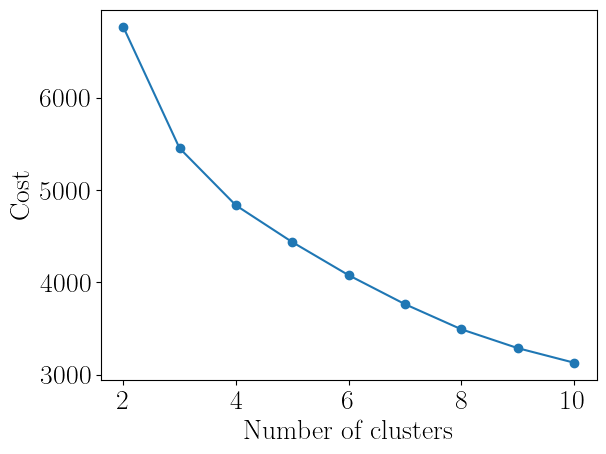

In [8]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [9]:
np.random.seed(342)
k = 6
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, normalize = True)

([], [])

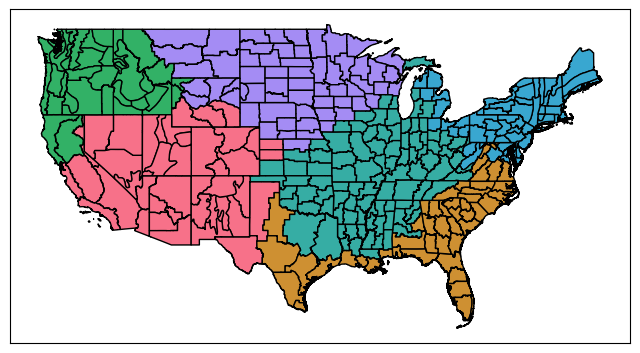

In [10]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = list(kmeans_labels[i])[0]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

plt.xticks([])
plt.yticks([])
#plt.savefig('../figures/climate/kmeans_map.png', bbox_inches = 'tight', dpi = 300)

(0.0, 1.0, 0.0, 1.0)

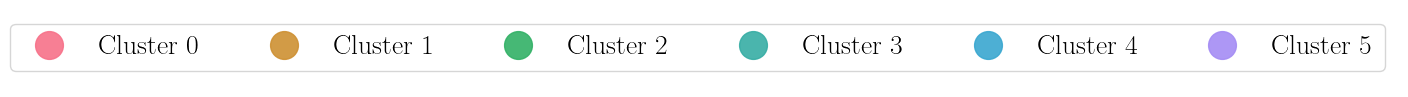

In [11]:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D([], [], marker = 'o', markersize=20, color=cmap_subset(i), lw=0, label=f'Cluster {i}', alpha=0.9)
    for i in range(k)
]
ax.legend(handles=legend_elements, ncol=6)
ax.axis('off')
#plt.savefig('../figures/climate/legend.png', bbox_inches = 'tight', dpi = 300)

### IMM / ExKMC

In [12]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_data_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_data_label_array = flatten_labels(exkmc_data_labels)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    exkmc_data_labels,
    unique_labels(exkmc_data_labels)
)

([], [])

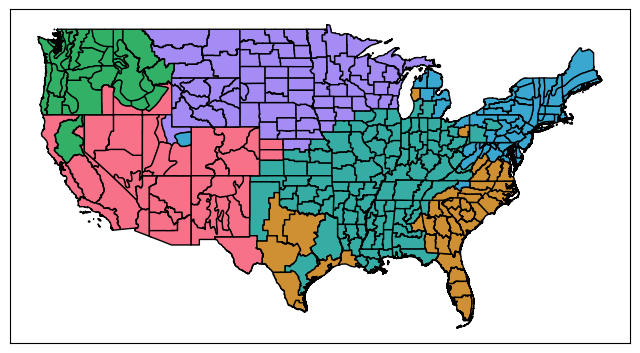

In [13]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = exkmc_data_label_array[i]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/imm_map.png', bbox_inches = 'tight', dpi = 300)

tree


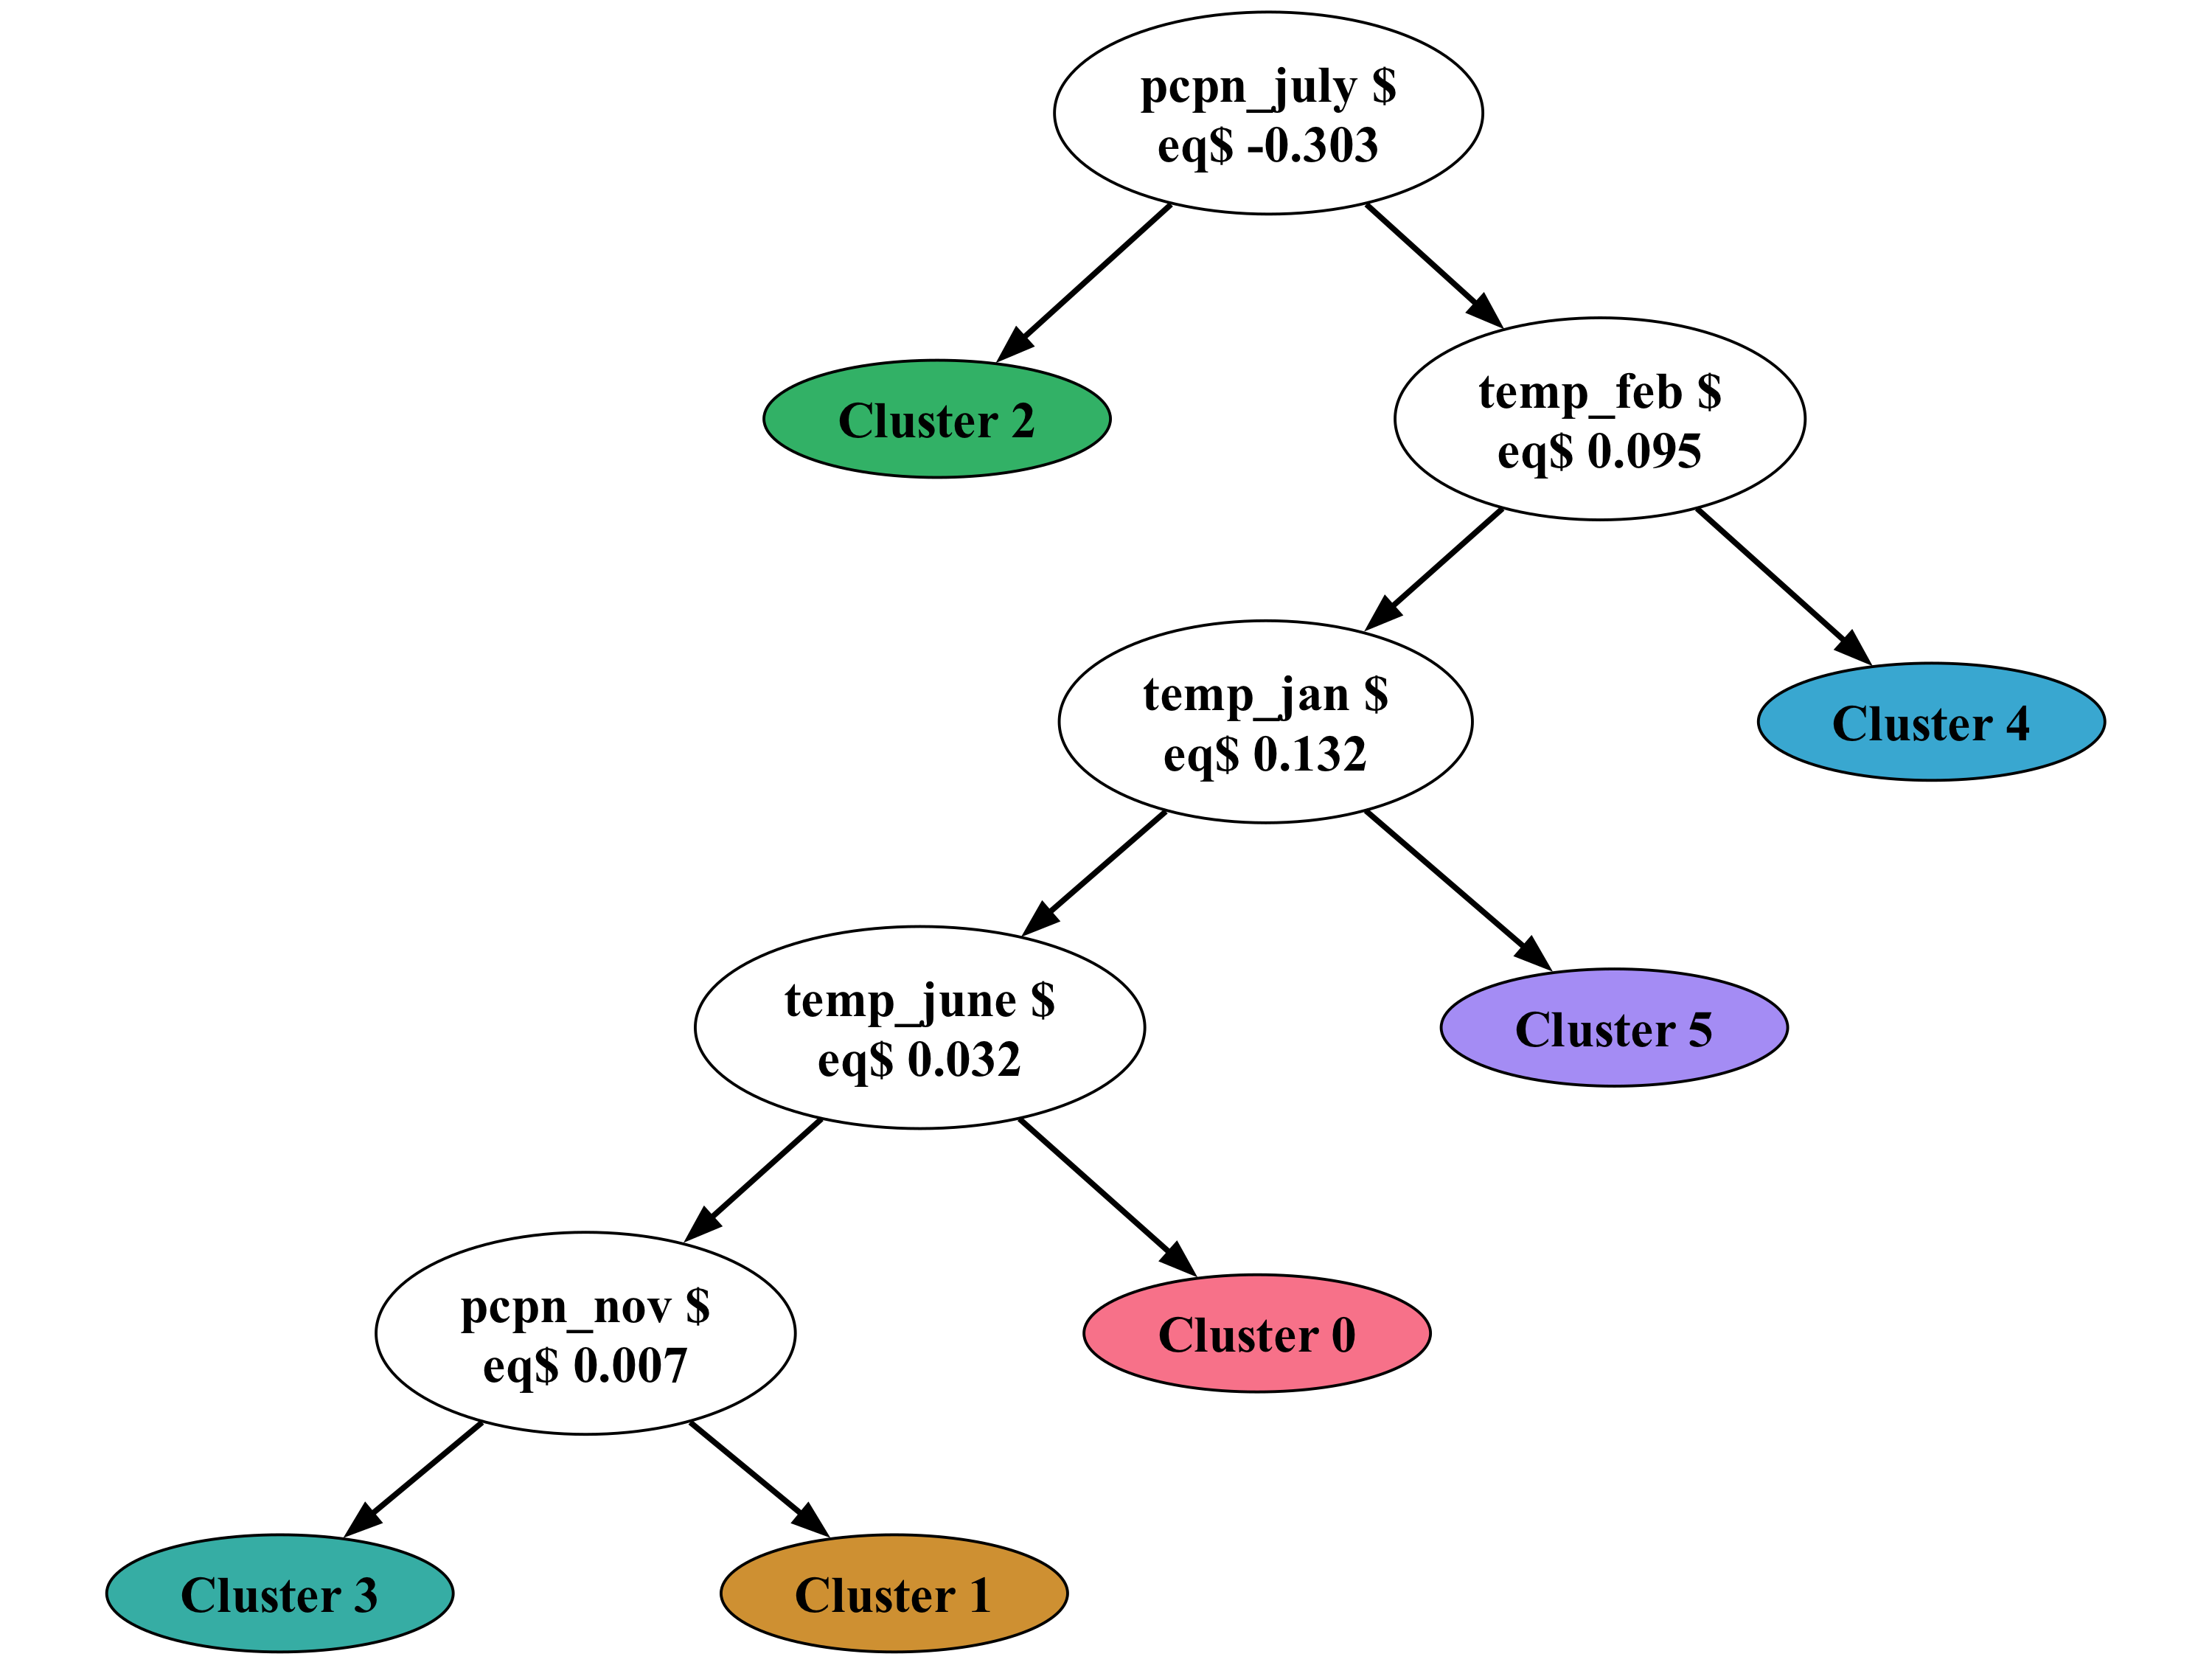

In [14]:
#fname = '../figures/climate/imm_tree.png'
fname = 'tree.png'
cluster_colors = {i: cmap_subset(i) for i in range(k)}
leaf_colors = {i:mcolors.rgb2hex(cmap_subset(i)) for i in range(k)}
visualize_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    leaf_colors = leaf_colors,
    display_node_info = False,
    output_file = fname
)

In [17]:
tree = ExTree(k, max_leaves = 14, base_tree =  'IMM')
exkmc_labels = tree.fit_predict(data, kmeans=kmeans)
exkmc_assignment = labels_to_assignment(exkmc_labels)
exkmc_centers = tree.all_centers
cost = kmeans_cost(data, exkmc_assignment, exkmc_centers, normalize = True)

TypeError: labels_to_assignment() missing 1 required positional argument: 'n_labels'

## Decision Forests

In [94]:
np.random.seed(342)

In [122]:
# Module Parameters:
k = 6
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

# Depth 5 Forest:
forest_tree_params_depth_5 = {
    'max_depth' : 5
}

forest_params_depth_5 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_5,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

# Oblique Forest:
oblique_forest_tree_params = {
    'max_depth' : 2
}

oblique_forest_params = {
    'tree_model' : ObliqueTree,
    'tree_params' : oblique_forest_tree_params,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}


# SVM Forest:
forest_tree_params_svm = {}

forest_params_svm = {
    'tree_model' : SVMTree,
    'tree_params' : forest_tree_params_svm,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}


# ExKMC Forest:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 2*k,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : 1,
    'max_features' : 24,
    'max_labels' : k,
    'feature_pairings' : [list(range(24))],
    'train_size' : 1
}


# Voronoi Decision Set:
voronoi_params = {
    'centers' : kmeans.cluster_centers_,
    'num_sets' : 1000,
    'num_conditions' : 2,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))]
}

In [ ]:
# Create and fit the forest models
forest = DecisionForest(**forest_params_depth_2)
forest_depth_5 = DecisionForest(**forest_params_depth_5)
oblique_forest = DecisionForest(**oblique_forest_params)

forest.fit(data, kmeans_labels)
forest_depth_5.fit(data, kmeans_labels)

# Oblique takes some time to run!
oblique_forest.fit(data, kmeans_labels)

In [131]:
svm_forest = DecisionForest(**forest_params_svm)
svm_forest.fit(data, kmeans_labels)

In [132]:
voronoi_set = VoronoiSet(**voronoi_params)
voronoi_set.fit(data, kmeans_labels)

In [123]:
exkmc_forest = DecisionForest(**forest_params_exkmc)
exkmc_forest.fit(data, kmeans_labels)

### Pruning

In [119]:
search_range = np.linspace(0,10,1001)
forest_method = exkmc_forest

data_to_rules_assignment = forest_method.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = forest_method.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

[(14.550042708926682, 0.8982558139534884), (14.550042708926682, 0.8982558139534884), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.279833962151942, 0.6627906976744186), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255813954), (13.286367534019803, 0.5843023255

Text(0, 0.5, 'Cost')

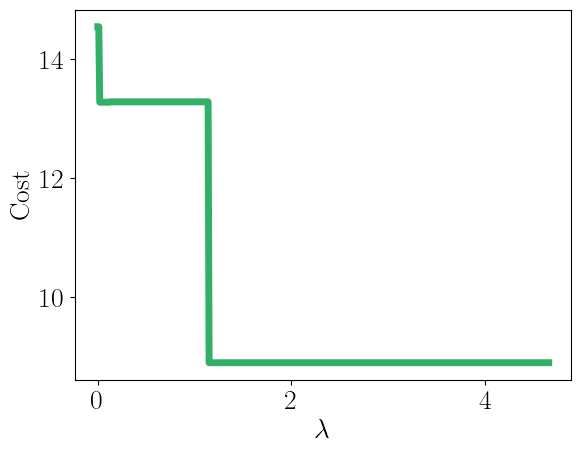

In [120]:
plt.plot(search_range, objective_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

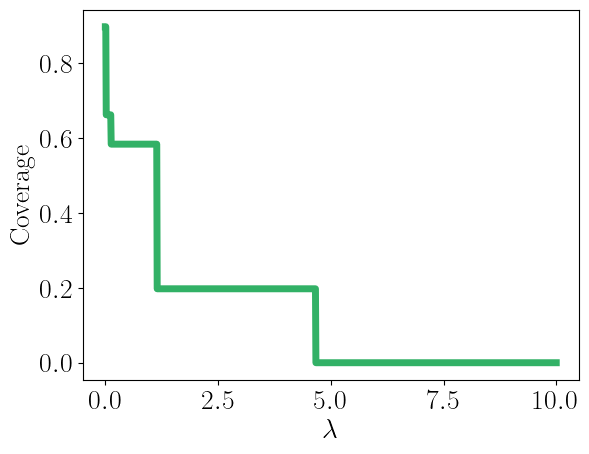

In [121]:
plt.plot(search_range, coverage_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [133]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.9,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,10,101),
    'full_search' : False,
    'cpu_count' : 4
}

In [134]:
forest.prune(**prune_params)
forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)

In [135]:
svm_forest.prune(**prune_params)
svm_forest_prune_predictions = svm_forest.pruned_predict(data, rule_labels = False)

ValueError: Decision set has not been pruned. If prune() was called, this is likely because coverage requirements were not met.

In [136]:
voronoi_set.prune(**prune_params)
voronoi_set_prune_predictions = voronoi_set.pruned_predict(data, rule_labels = False)

In [129]:
exkmc_forest.prune(**prune_params)
exkmc_forest_prune_predictions = exkmc_forest.pruned_predict(data, rule_labels = False)

ValueError: Decision set has not been pruned. If prune() was called, this is likely because coverage requirements were not met.

In [111]:
len(exkmc_forest.decision_set)

12

In [112]:
exkmc_forest.prune_status

True

In [99]:
forest.prune(**prune_params)
forest_depth_5.prune(**prune_params)
oblique_forest.prune(**prune_params)

forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)
forest_depth_5_prune_predictions = forest_depth_5.pruned_predict(data, rule_labels = False)
oblique_forest_prune_predictions = oblique_forest.pruned_predict(data, rule_labels = False)

([], [])

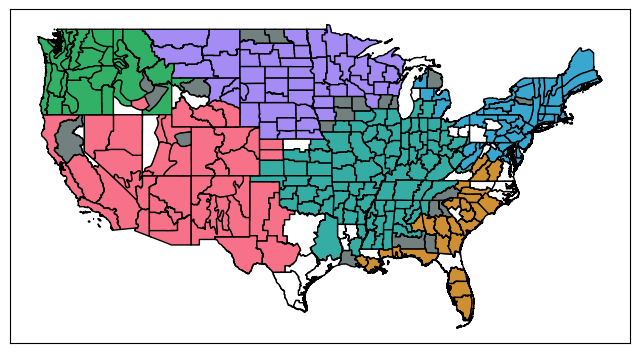

In [53]:
prune_predictions = forest_prune_predictions
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            color_label_array[idx[0]] = l[0]
        elif len(l) > 1:
            color_label_array[idx[0]] = -1
        else:
            color_label_array[idx[0]] = -2

gdf['color'] = color_label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/forest_map.png', bbox_inches = 'tight', dpi = 300)

In [42]:
'''
# Plots for individual rules:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)
for r in range(7):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    #plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)
'''

'\n# Plots for individual rules:\n#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)\nfor r in range(7):\n    r_labels = np.zeros(len(data)) - 1\n    r_labels[rule_covers[selected_rules[r]]] = r\n    \n    label_array = np.empty(len(gdf))\n    label_array[:] = np.nan\n    for i,ide in enumerate(climate_change.index):\n        idx = gdf.loc[gdf.CLIMDIV == ide].index\n        if len(idx) == 1:\n            label_array[idx[0]] = r_labels[i]\n\n    fig,ax = plt.subplots(dpi = 100)\n    c = selected_rule_labels[r]\n    new_cmap = ["white", cmap_subset(c)]\n    new_cmap = ListedColormap(new_cmap)\n    gdf[\'cluster\'] = label_array\n    gdf.plot(column=\'cluster\', cmap=new_cmap, ax = ax, legend=False, edgecolor = \'black\', alpha = 1)\n    plt.xticks([])\n    plt.yticks([]) \n    #plt.savefig(\'../figures/decision_sets/rule_\' + str(r) + \'.png\', bbox_inches = \'tight\', dpi = 300)\n'

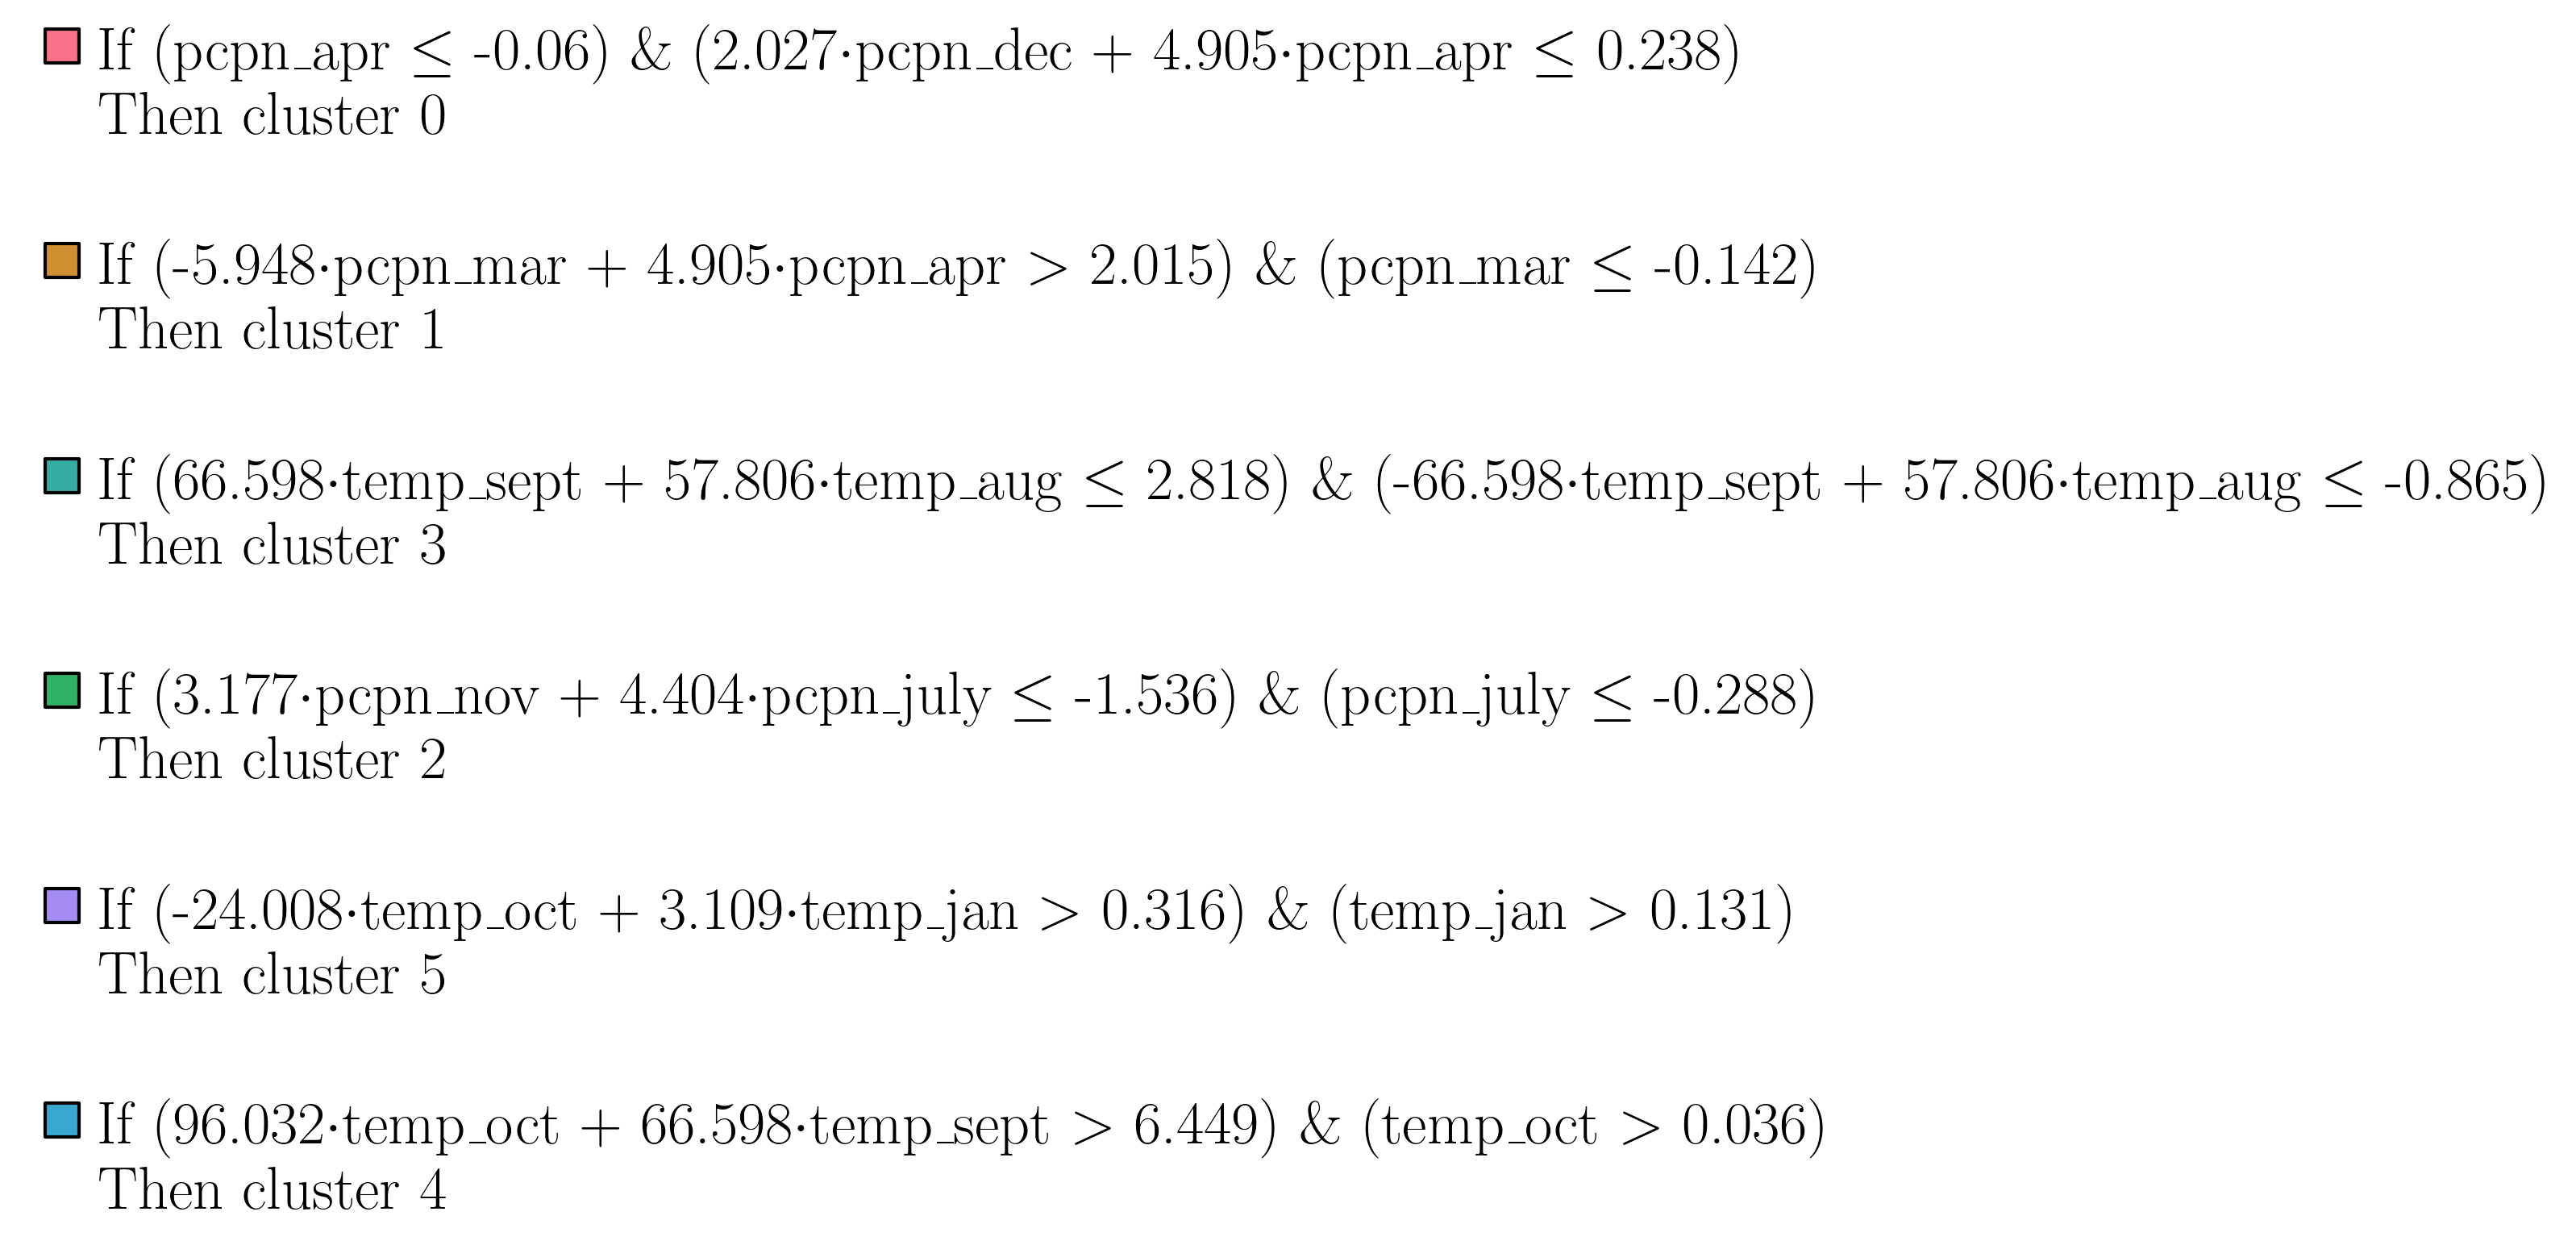

In [21]:
forest_method = oblique_forest
#fname = '../figures/climate/forest_decision_set.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    decision_set = [forest_method.decision_set[i] for i in forest_method.pruned_indices],
    rule_labels = [forest_method.decision_set_labels[i] for i in forest_method.pruned_indices],
    feature_labels = feature_labels,
    data_scaler = scaler,
    cluster_colors = cluster_colors,
    filename = fname
)

### Distance Ratio Distributions

In [22]:
prune_predictions = oblique_forest_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)
distance_ratios = distance_ratio(data, centers)

# Single Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_distance_ratios = distance_ratios[uncovered_mask]

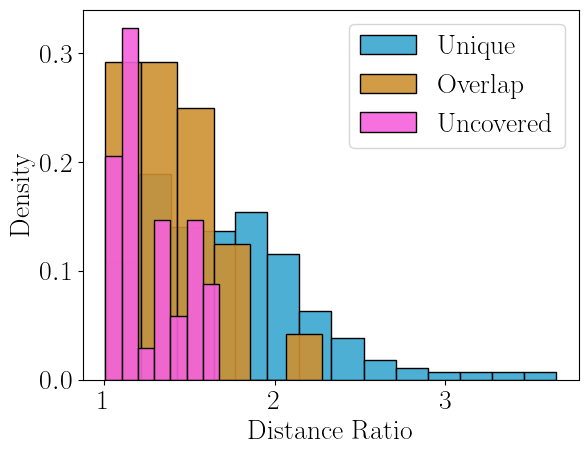

In [24]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.9, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.9, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.9, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()
#plt.savefig('../figures/climate/oblique_forest_cover_dist.png', bbox_inches = 'tight', dpi = 300)


## Voronoi Sets

In [ ]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

vor = VoronoiSet(
    centers = kmeans.cluster_centers_, 
    num_sets = 1000,
    num_conditions = 2,
    feature_pairings = feature_pairings
)
vor.fit(data, kmeans_labels)

In [14]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True
)

vor.prune(
    n_rules = 7,
    frac_cover = 0.75,
    n_clusters = 7,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    lambda_search_range = np.linspace(0,10,101)
    #lambda_search_range = [10]
)
prune_predictions = vor.pruned_predict(data, rule_labels = False)

([], [])

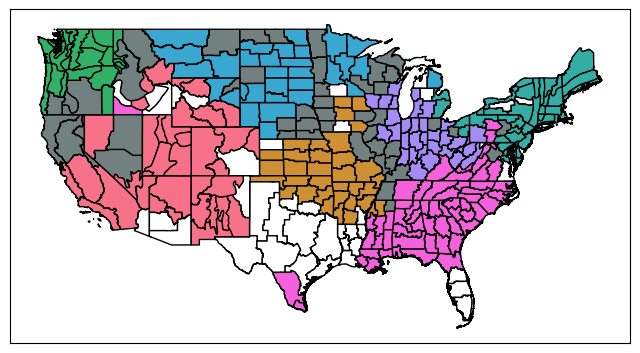

In [15]:
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            label_array[idx[0]] = l[0]
        elif len(l) > 1:
            label_array[idx[0]] = -1
        else:
            label_array[idx[0]] = -2

gdf['cluster'] = label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

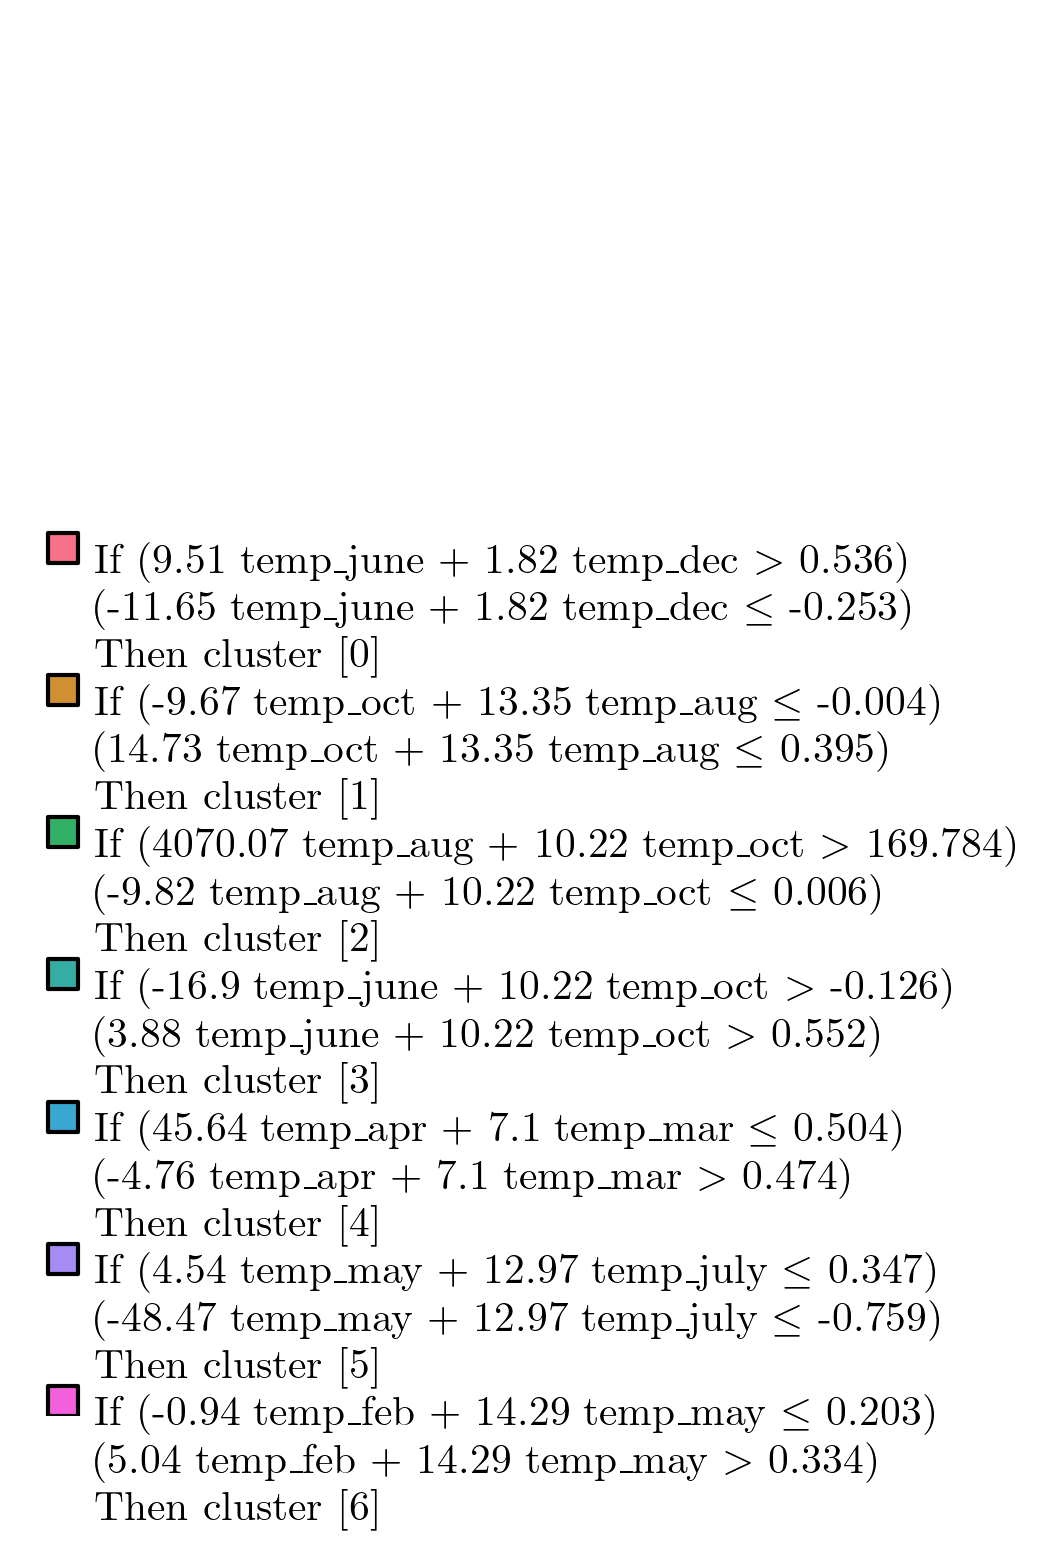

In [16]:
#fname = '../figures/climate/forest_rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [vor.decision_set[i] for i in vor.pruned_indices],
    feature_labels,
    [vor.decision_set_labels[i] for i in vor.pruned_indices],
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)